importing notebook from Study.ipynb
 Preparing Data (1/2) 100.0%
Painting matrix (2/2)


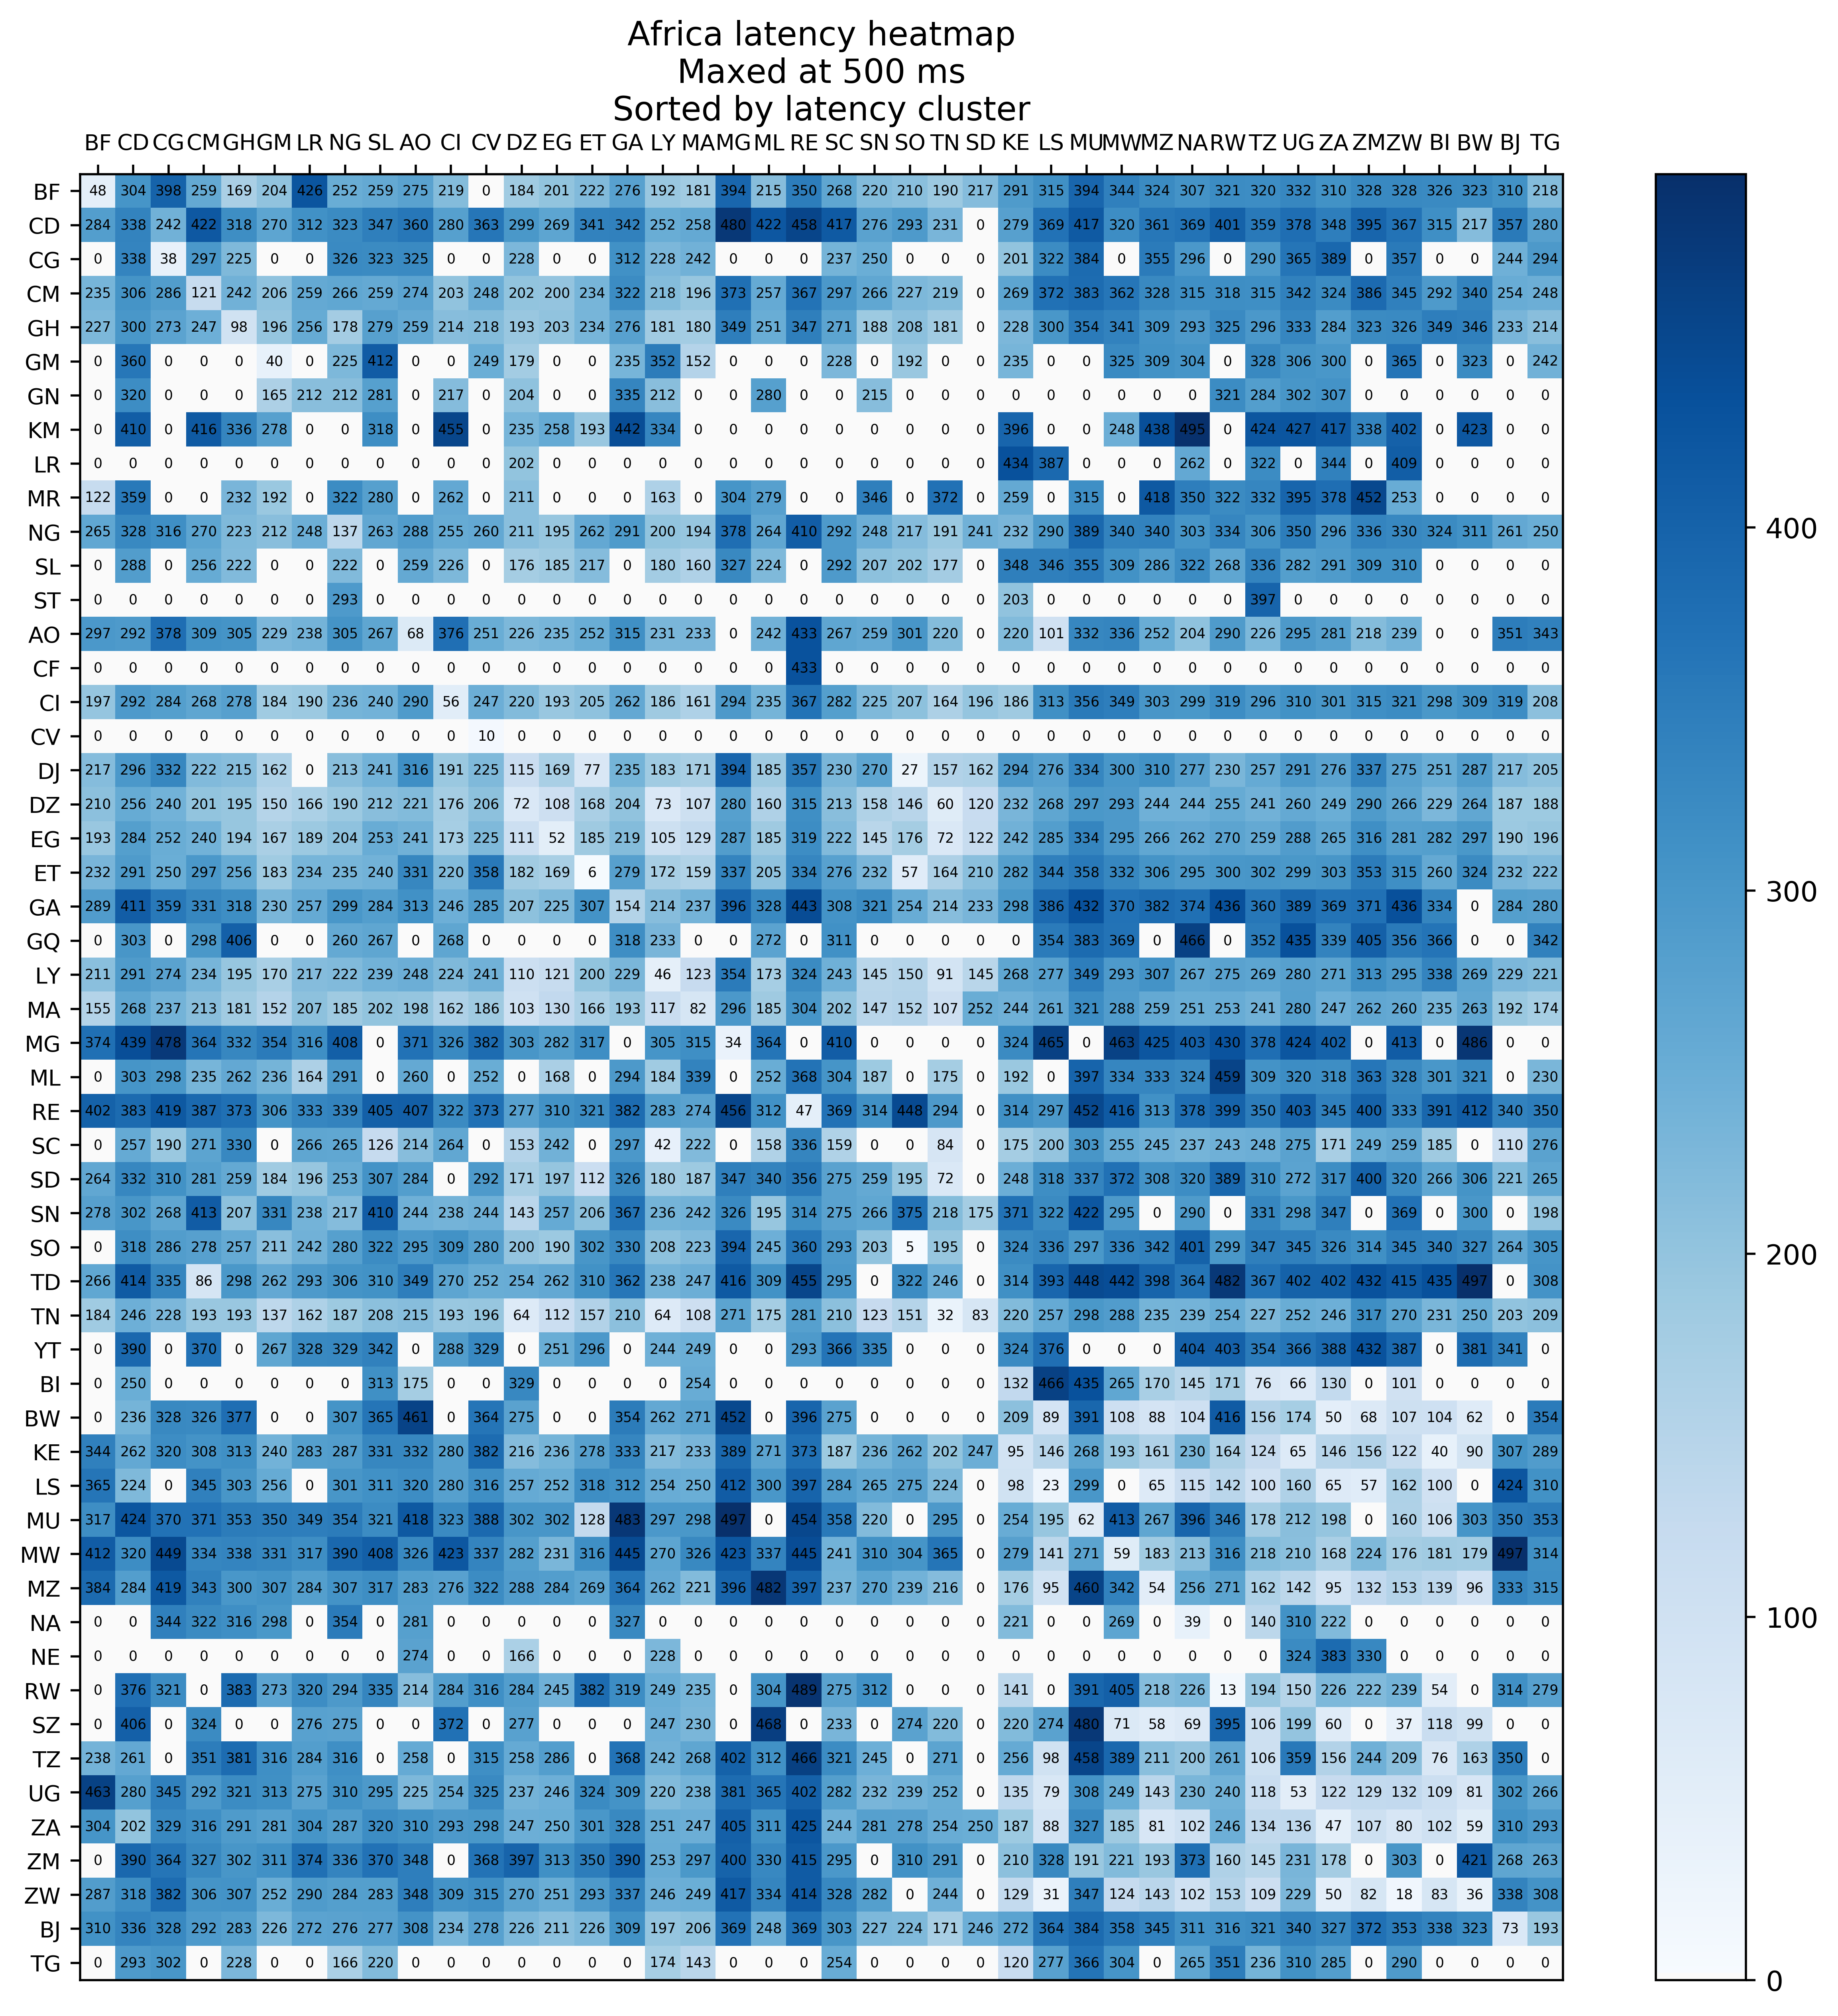

Building dict 100.00%Graph 'G' information:
Name: 
Type: Graph
Number of nodes: 53
Number of edges: 1067
Average degree:  40.2642
Dendogram information:
[{u'BF': 0, u'DJ': 1, u'BI': 2, u'BJ': 0, u'BW': 3, u'DZ': 0, u'ET': 0, u'YT': 0, u'RW': 2, u'TZ': 3, u'CM': 5, u'NA': 3, u'CD': 0, u'NE': 4, u'NG': 0, u'TN': 0, u'RE': 0, u'LR': 0, u'LS': 3, u'TG': 0, u'TD': 5, u'LY': 4, u'ZM': 3, u'CI': 0, u'GQ': 4, u'EG': 0, u'SL': 0, u'CG': 0, u'CF': 0, u'AO': 0, u'ZA': 3, u'GA': 0, u'GN': 0, u'GM': 0, u'ZW': 3, u'CV': 0, u'GH': 0, u'SZ': 3, u'MG': 0, u'MA': 0, u'KE': 2, u'ML': 0, u'KM': 3, u'ST': 2, u'MU': 2, u'MW': 3, u'SO': 1, u'SN': 0, u'MR': 0, u'SC': 4, u'UG': 3, u'SD': 0, u'MZ': 3}, {0: 0, 1: 1, 2: 2, 3: 2, 4: 0, 5: 0}]


In [11]:
from notebook_importer import *
import Commons
import Study

In [17]:
Result = Study.Result
ccs = Commons.ccs
atlas_reader = Commons.atlas_reader
get_cc_from_ip_address = Commons.get_cc_from_ip_address

In [18]:
import json

f = open('data/results-africa-connectivity.json')
data = f.read()
rs_speed = json.loads(data)
results = [Result.parse_speedchecker_result(r) for r in rs_speed]

In [20]:
import requests
import json

# measurements = ['8459135', '8459202', '8459184', '8459217', '8459172', '8459146', '8459168']#['8366457', '8366460', '8366461', '8366462', '8366467', '8366475', '8366280', '8366281', '8366284', '8366289', '8366294', '8366301']
measurements = ['8459135']#, '8459146', '8459161', '8459168', '8459172', '8459184', '8459168', '8459202', '8459217', '8459228', '8459236']


rs_atlas = []
for m in measurements:
    response = requests.get("https://atlas.ripe.net/api/v2/measurements/%s/results" % m)
    rs_atlas += [Result.parse_atlas_ping_result(r) for r in json.loads(response.text)]
#     break

In [27]:
vars(rs_atlas[0])

{'as_destination': 0,
 'as_origin': 0,
 'avg_rtt': 256.563396,
 'country_destination': '',
 'country_origin': '',
 'date_probe': 0,
 'date_target': 0,
 'date_utc': datetime.datetime(2017, 5, 7, 2, 1, 52),
 'ip_destination': 0,
 'ip_origin': u'197.84.150.123',
 'max_rtt': 270.116765,
 'med_rtt': 253.69792,
 'min_rtt': 247.866525,
 'prb_id': 11383,
 'rtt_list': [250.405245,
  247.866525,
  252.77012,
  269.202925,
  264.02001,
  256.240705,
  249.44953,
  250.936415,
  270.116765,
  254.62572]}

In [28]:
prbs = [str(r.prb_id) for r in rs_atlas]

In [29]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunks = list(chunks(list(set(prbs)), 10))

In [7]:
responses = []
for i, ps in enumerate(chunks):
    response = requests.get(
        "https://atlas.ripe.net/api/v2/probes?id__in=%s&fields=asn_v4" % (','.join(ps))
    ).text
    responses.append(response)
    
    print i+1, len(chunks)

1 25
2 25
3 25
4 25
5 25
6 25
7 25
8 25
9 25
10 25
11 25
12 25
13 25
14 25
15 25
16 25
17 25
18 25
19 25
20 25
21 25
22 25
23 25
24 25
25 25


In [8]:
import json
from collections import defaultdict

asns_atlas = []
for page in responses:
    j = json.loads(page)
    for res in j['results']:
        asns_atlas.append(res['asn_v4'])
        
probes_to_asn = defaultdict(list)
for page in responses:
    j = json.loads(page)
    for res in j['results']:
        as_origin = res['asn_v4']
        prb_id = res['id']
        probes_to_asn[prb_id] = as_origin

In [9]:
asns = list(set(asns_atlas))

In [10]:
from collections import defaultdict

rs_speed_from_asns = defaultdict(list)
for r in rs_speed:
    rs_speed_from_asns[r['as_origin']].append(r['min_rtt'])
    
rs_atlas_from_asns = defaultdict(list)
for r in rs_atlas:
    prb_id = r['prb_id']
    for res in r['result']:
        try:
            as_origin = probes_to_asn[prb_id]
            rtt = res['rtt']
            rs_atlas_from_asns[as_origin].append(rtt)
        except Exception as e:
#             print e, res
            continue

In [11]:
import geoip2.database as geo

def get_cc_from_ip_address(ip_address):
    error = "XX"
    try:
        reader = geo.Reader("/Users/agustin/Desktop/GeoLite2-City.mmdb")
        cc = reader.city(ip_address).country.iso_code
    except Exception as e:
        cc = error
        print e
    return cc

def get_geo_info_form_ip_address(ip_address):
    try:
        reader = geo.Reader("/Users/agustin/Desktop/GeoLite2-City.mmdb")
        return reader.city(ip_address)
    except Exception as e:
        return None

In [13]:
import numpy as np

rtts_atlas = []
errors = []
for r in rs_atlas:
    for s in r['result']:
        try:
            rtts_atlas.append(s['rtt'])
        except Exception as e:
            errors.append(s)
            continue

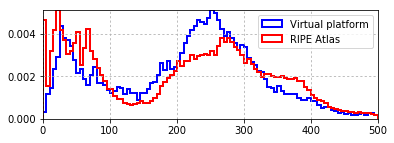

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

rtts_speed = [float(r['min_rtt']) for r in rs_speed if r['as_origin'] in asns]

plt.figure(figsize=(6,2))

plt.hist(
    [rtts_atlas, rtts_speed],
    range=(0, 500),
    histtype='step',
    normed=True,
    bins=100,
    cumulative=False,
    linewidth=2.0,
    color=['red', 'blue'],
    label=["RIPE Atlas", "Virtual platform"]
)

plt.legend(loc='upper right')

plt.margins(.0)
plt.grid(linestyle='dotted')

plt.savefig('figs/platform-comparison.png')
plt.savefig('figs/platform-comparison.pdf')

plt.show()

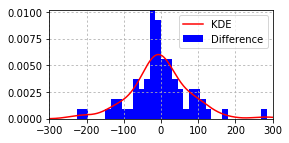

In [19]:
import numpy as np
from scipy import stats

diffs = []
for asn in set(rs_atlas_from_asns.keys()).intersection(rs_speed_from_asns.keys()):
    rtts_speed = rs_speed_from_asns[asn]
    rtts_atlas = rs_atlas_from_asns[asn]
    diffs.append(np.median(rtts_atlas) - np.median(rtts_speed))
    

plt.figure(figsize=(4,2))


plt.hist(
    diffs,
    histtype='bar',
    normed=True,
    bins=40,
    cumulative=False,
    linewidth=2.0,
    range=(-300, 300),
    color='blue',
    label=['Difference']
)


kde = stats.gaussian_kde(diffs)
xx = np.linspace(-300, 300, 1000)
plt.plot(
    xx,
    kde(xx),
    color='red',
    label='KDE'
)

plt.margins(.0)
plt.grid(linestyle='dotted')
plt.legend()


plt.savefig('figs/platform-comparison-diffs.png', dpi=500)
plt.savefig('figs/platform-comparison-diffs.pdf', dpi=500)

plt.show()

In [16]:
np.std(diffs)

78.736222445389672

In [17]:
len([d for d in diffs if d < 0])

41